# Non-Stationary Kernels

In [ ]:
import tensorflow as tf
import numpy as np
import gpflow
gpflow.config.set_default_float(np.float32)

from sgptools.utils.metrics import *
from sgptools.utils.misc import *
from sgptools.models.continuous_sgp import *
from sgptools.kernels.attentive_kernel import AttentiveKernel
from sgptools.kernels.neural_kernel import init_neural_kernel
from sgptools.utils.gpflow import get_model_params

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.random.seed(10)
tf.random.set_seed(10)

## Generate synthetic non-stationary data

Train Data: (800, 2) (800, 1)
Test Data: (5000, 2) (5000, 1)


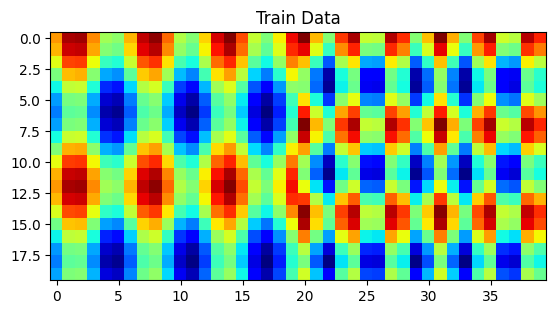

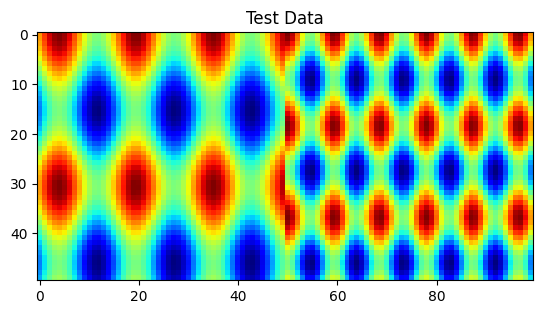

In [2]:
def non_stationary_function(X, Y):
    Z1 = np.sin(X/10) + np.cos(Y/10)
    Z2 = np.cos(X/6) + np.cos(Y/6)
    Z = np.concatenate([Z1[:, ::2], Z2[:, ::2]], 
                       axis=1)
    return Z

# Generate data
train_data_dims = (40, 20)
x = np.linspace(0, 200, train_data_dims[0])
y = np.linspace(0, 100, train_data_dims[1])
X, Y = np.meshgrid(x, y)
Z = non_stationary_function(X, Y)

X_train = np.stack([X.ravel(), Y.ravel()], 
                   axis=1).astype(np.float32)
Y_train = Z.ravel()[:, None].astype(np.float32)
print('Train Data:', X_train.shape, Y_train.shape)

test_data_dims = (100, 50)
x = np.linspace(0, 200, test_data_dims[0])
y = np.linspace(0, 100, test_data_dims[1])
X, Y = np.meshgrid(x, y)
Z = non_stationary_function(X, Y)

X_test = np.stack([X.ravel(), Y.ravel()], 
                  axis=1).astype(np.float32)
Y_test = Z.ravel()[:, None].astype(np.float32)
print('Test Data:', X_test.shape, Y_test.shape)

# Normalize the data
Xscalar = StandardScaler()
X_train = Xscalar.fit_transform(X_train)
X_test = Xscalar.transform(X_test)

yScalar = StandardScaler()
Y_train = yScalar.fit_transform(Y_train)
Y_test = yScalar.transform(Y_test)

# Plot the data
plt.figure()
plt.imshow(Y_train.reshape(train_data_dims[1], 
                           train_data_dims[0]), 
           cmap='jet')
plt.gca().set_aspect('equal')
plt.title('Train Data')
plt.show()

plt.figure()
plt.imshow(Y_test.reshape(test_data_dims[1], 
                          test_data_dims[0]), 
           cmap='jet')
plt.gca().set_aspect('equal')
plt.title('Test Data')
plt.show()

## Learn kernel parameters from train data 

In [3]:
kernels = []
noice_vars = []
labels = []

In [4]:
# Non Stationary Neural Kernel
model = init_neural_kernel(X_train, Y_train, 
                           n_inits=5,
                           inducing_variable=get_inducing_pts(X_train, 100),
                           Q=3, 
                           hidden_sizes=(4, 4))
optimize_model(model)

kernels.append(model.kernel)
noice_vars.append(model.likelihood.variance.numpy())
labels.append('Neural Kernel')

Initializing neural spectral kernel...
Best init: -1180.817993


In [5]:
# Non Stationary Attentive Kernel
_, attentive_noise_variance, attentive_kernel = get_model_params(X_train, Y_train, 
                                                                 kernel=AttentiveKernel(np.linspace(0.1, 2.0, 4), 
                                                                                        dim_hidden=10))
kernels.append(attentive_kernel)
noice_vars.append(attentive_noise_variance)
labels.append('Attentive Kernel')

╒════════════════════════════╤══════════════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤═════════════════════════════════════════╕
│ name                       │ class            │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                                   │
╞════════════════════════════╪══════════════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪═════════════════════════════════════════╡
│ GPR.kernel._free_amplitude │ ResourceVariable │                  │         │ True        │ ()       │ float32 │ 1.00447                                 │
├────────────────────────────┼──────────────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼─────────────────────────────────────────┤
│ GPR.kernel.lengthscales    │ ResourceVariable │                  │         │ False       │ (4,)     │ float32 │ [0.1, 0.73333335, 1.36667...            │
├────────────────────────────┼──────────────────┼───────────────

In [6]:
# Stationary RBF Kernel
_, rbf_noise_variance, rbf_kernel = get_model_params(X_train, Y_train, 
                                                     lengthscales=[1.0, 0.5])
kernels.append(rbf_kernel)
noice_vars.append(rbf_noise_variance)
labels.append('RBF Kernel')

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float32 │ 0.59744877              │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float32 │ [1.16522    0.37076756] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ floa

## Continuous-SGP solution from each kernel function

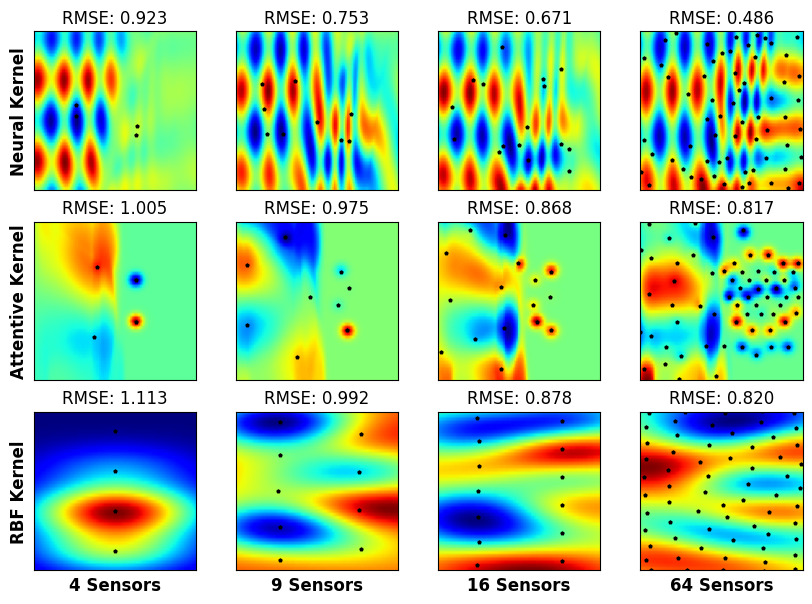

In [7]:
num_placements_list = [4, 9, 16, 64]
fig, axs = plt.subplots(len(kernels), len(num_placements_list), figsize=(10, 7))
for i, (kernel, noice_var) in enumerate(zip(kernels, noice_vars)):
        for j, num_placements in enumerate(num_placements_list):
                # Get initial inducing points
                Xu_init = get_inducing_pts(X_train, num_placements)*0.5
                Xu_init.astype(np.float32)

                # Setup SGP and optimize it
                sgpr, _ = continuous_sgp(num_placements, 
                                         X_train,
                                         noise_variance=noice_var,
                                         kernel=kernel,
                                         Xu_init=Xu_init)
                sgp_sol_sp = sgpr.inducing_variable.Z.numpy()

                # Get the GP predictions
                Xu_X, Xu_y = cont2disc(sgp_sol_sp, candidates=X_test,
                                       candidate_labels=Y_test)
                gpr = gpflow.models.GPR((Xu_X, Xu_y),
                                        noise_variance=noice_var,
                                        kernel=kernel)
                y_pred, y_var = gpr.predict_f(X_test)
                y_pred = y_pred.numpy()

                rmse = np.sqrt(np.mean((y_pred - Y_test)**2))

                # Plot the results
                axs[i, j].imshow(y_pred.reshape(test_data_dims[1], test_data_dims[0]),
                                 cmap='jet', origin='lower',
                                 extent=[np.min(X_test[:, 0]), np.max(X_test[:, 0]),
                                         np.min(X_test[:, 1]), np.max(X_test[:, 1])])
                axs[i, j].set_aspect('equal')
                axs[i, j].scatter(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], c='k', marker='p', s=5)
                axs[i, j].set_title(f'RMSE: {rmse:.3f}')
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])
                axs[i, j].set_xlim([np.min(X_test[:, 0]), np.max(X_test[:, 0])])
                axs[i, j].set_ylim([np.min(X_test[:, 1]), np.max(X_test[:, 1])])

                if j==0:
                        axs[i, j].set_ylabel(f'{labels[i]}', fontsize='large', fontweight="bold")

                if i==len(kernels)-1:
                        axs[i, j].set_xlabel(f'{num_placements} Sensors', fontsize='large', fontweight="bold")

- The neural kernel performs the best but requires a large number of training samples and computational power
- The attentive kernel seems to perform poorly, but note that the sensing locations are in more strategic locations compared to the RBF kernel
- Using a better reconstruction method for the attentive kernel-based solution would yield considerably better results than the RBF kernel-based solution